In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
plt.rcParams['figure.dpi'] = 600

posterior_chuong = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
posterior_ensemble = pickle.load(open(f'posteriors/ensemble/Chuong_ensemble100_ensemble.pkl', 'rb'))
posterior_noisy = pickle.load(open(f'posteriors/posterior_chuong_noisy_100.pkl', 'rb'))

# Network losses through training

Text(0, 0.5, 'Loss')

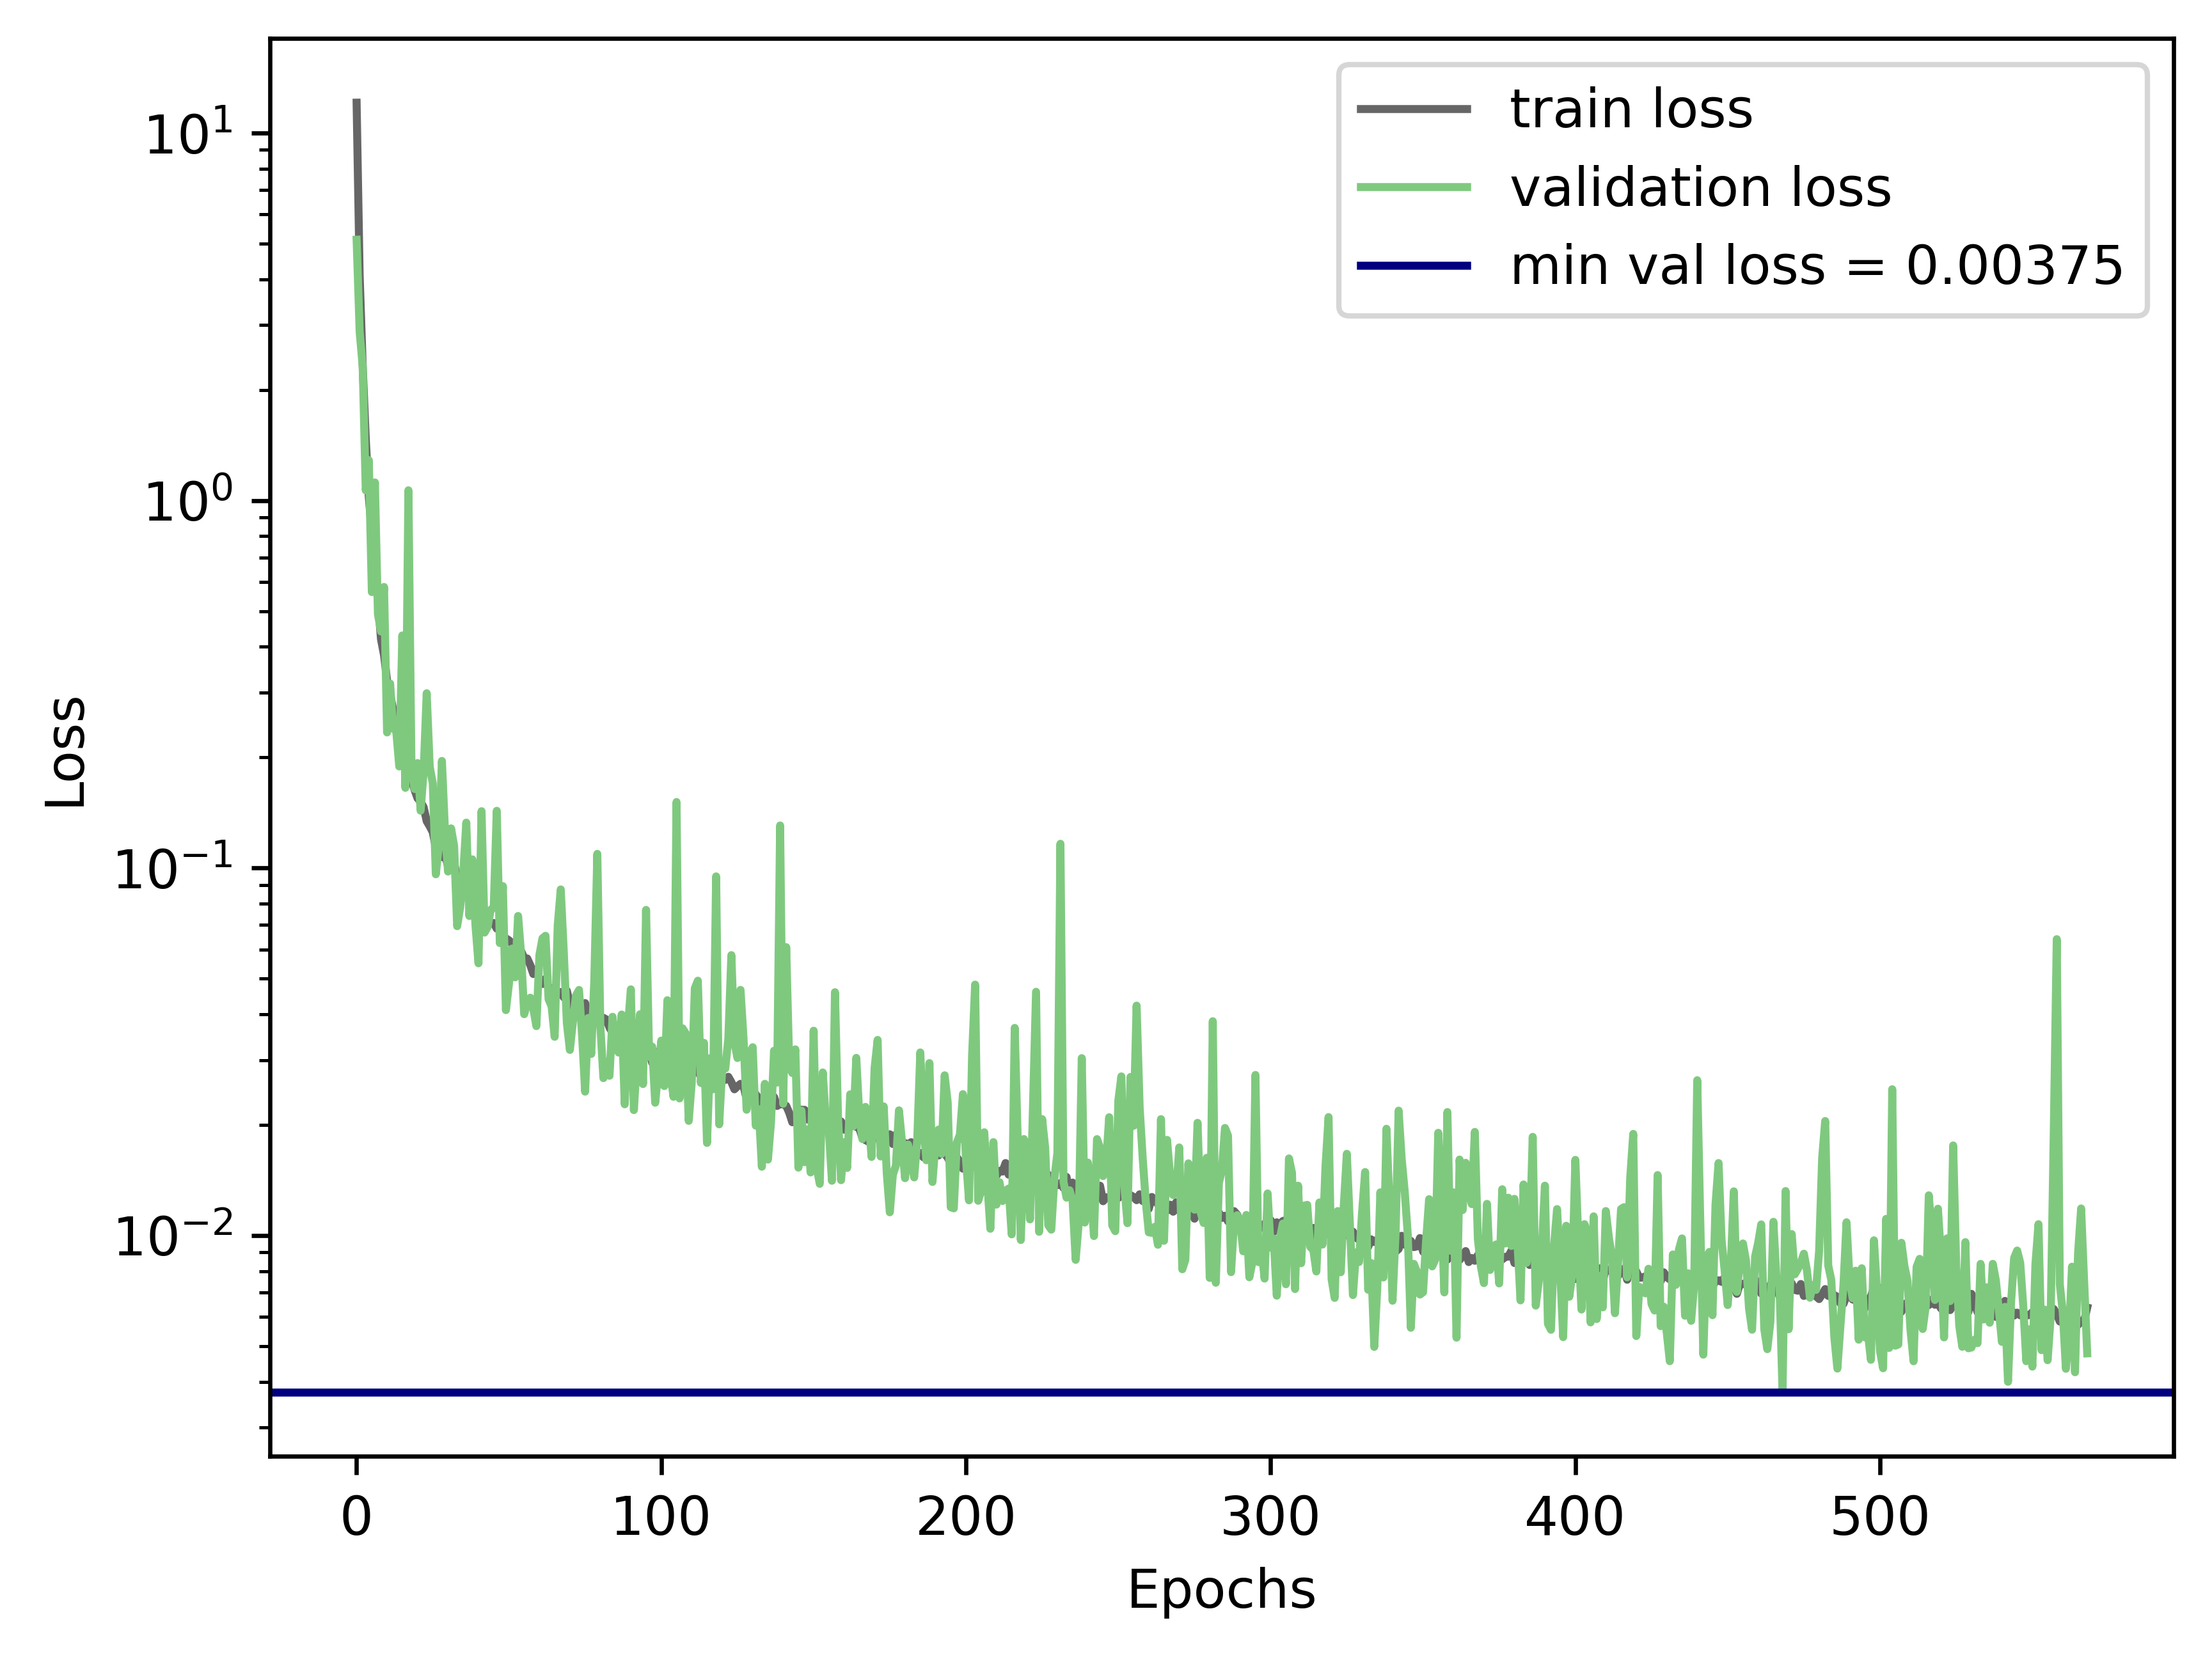

In [2]:
losses_100 = pd.read_csv('losses/losses_100_epochs_chuong.csv')
losses_100 = np.e**(-1*losses_100)
minloss_100 = losses_100['validation loss'].min()
losses_100.plot(colormap = 'Accent_r')
plt.axhline(minloss_100, label = f'min val loss = {round(minloss_100,5)}', color = 'navy')
plt.legend()
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Synthetic Validations
# 2,000 simulations

## Prior: $-2 \leq log_{10}(s_C)\leq-0.7$, $-6 \leq log_{10}(\delta_C)\leq-3$, $-8 \leq log_{10}(p_0)\leq-3$ (not uniform)

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


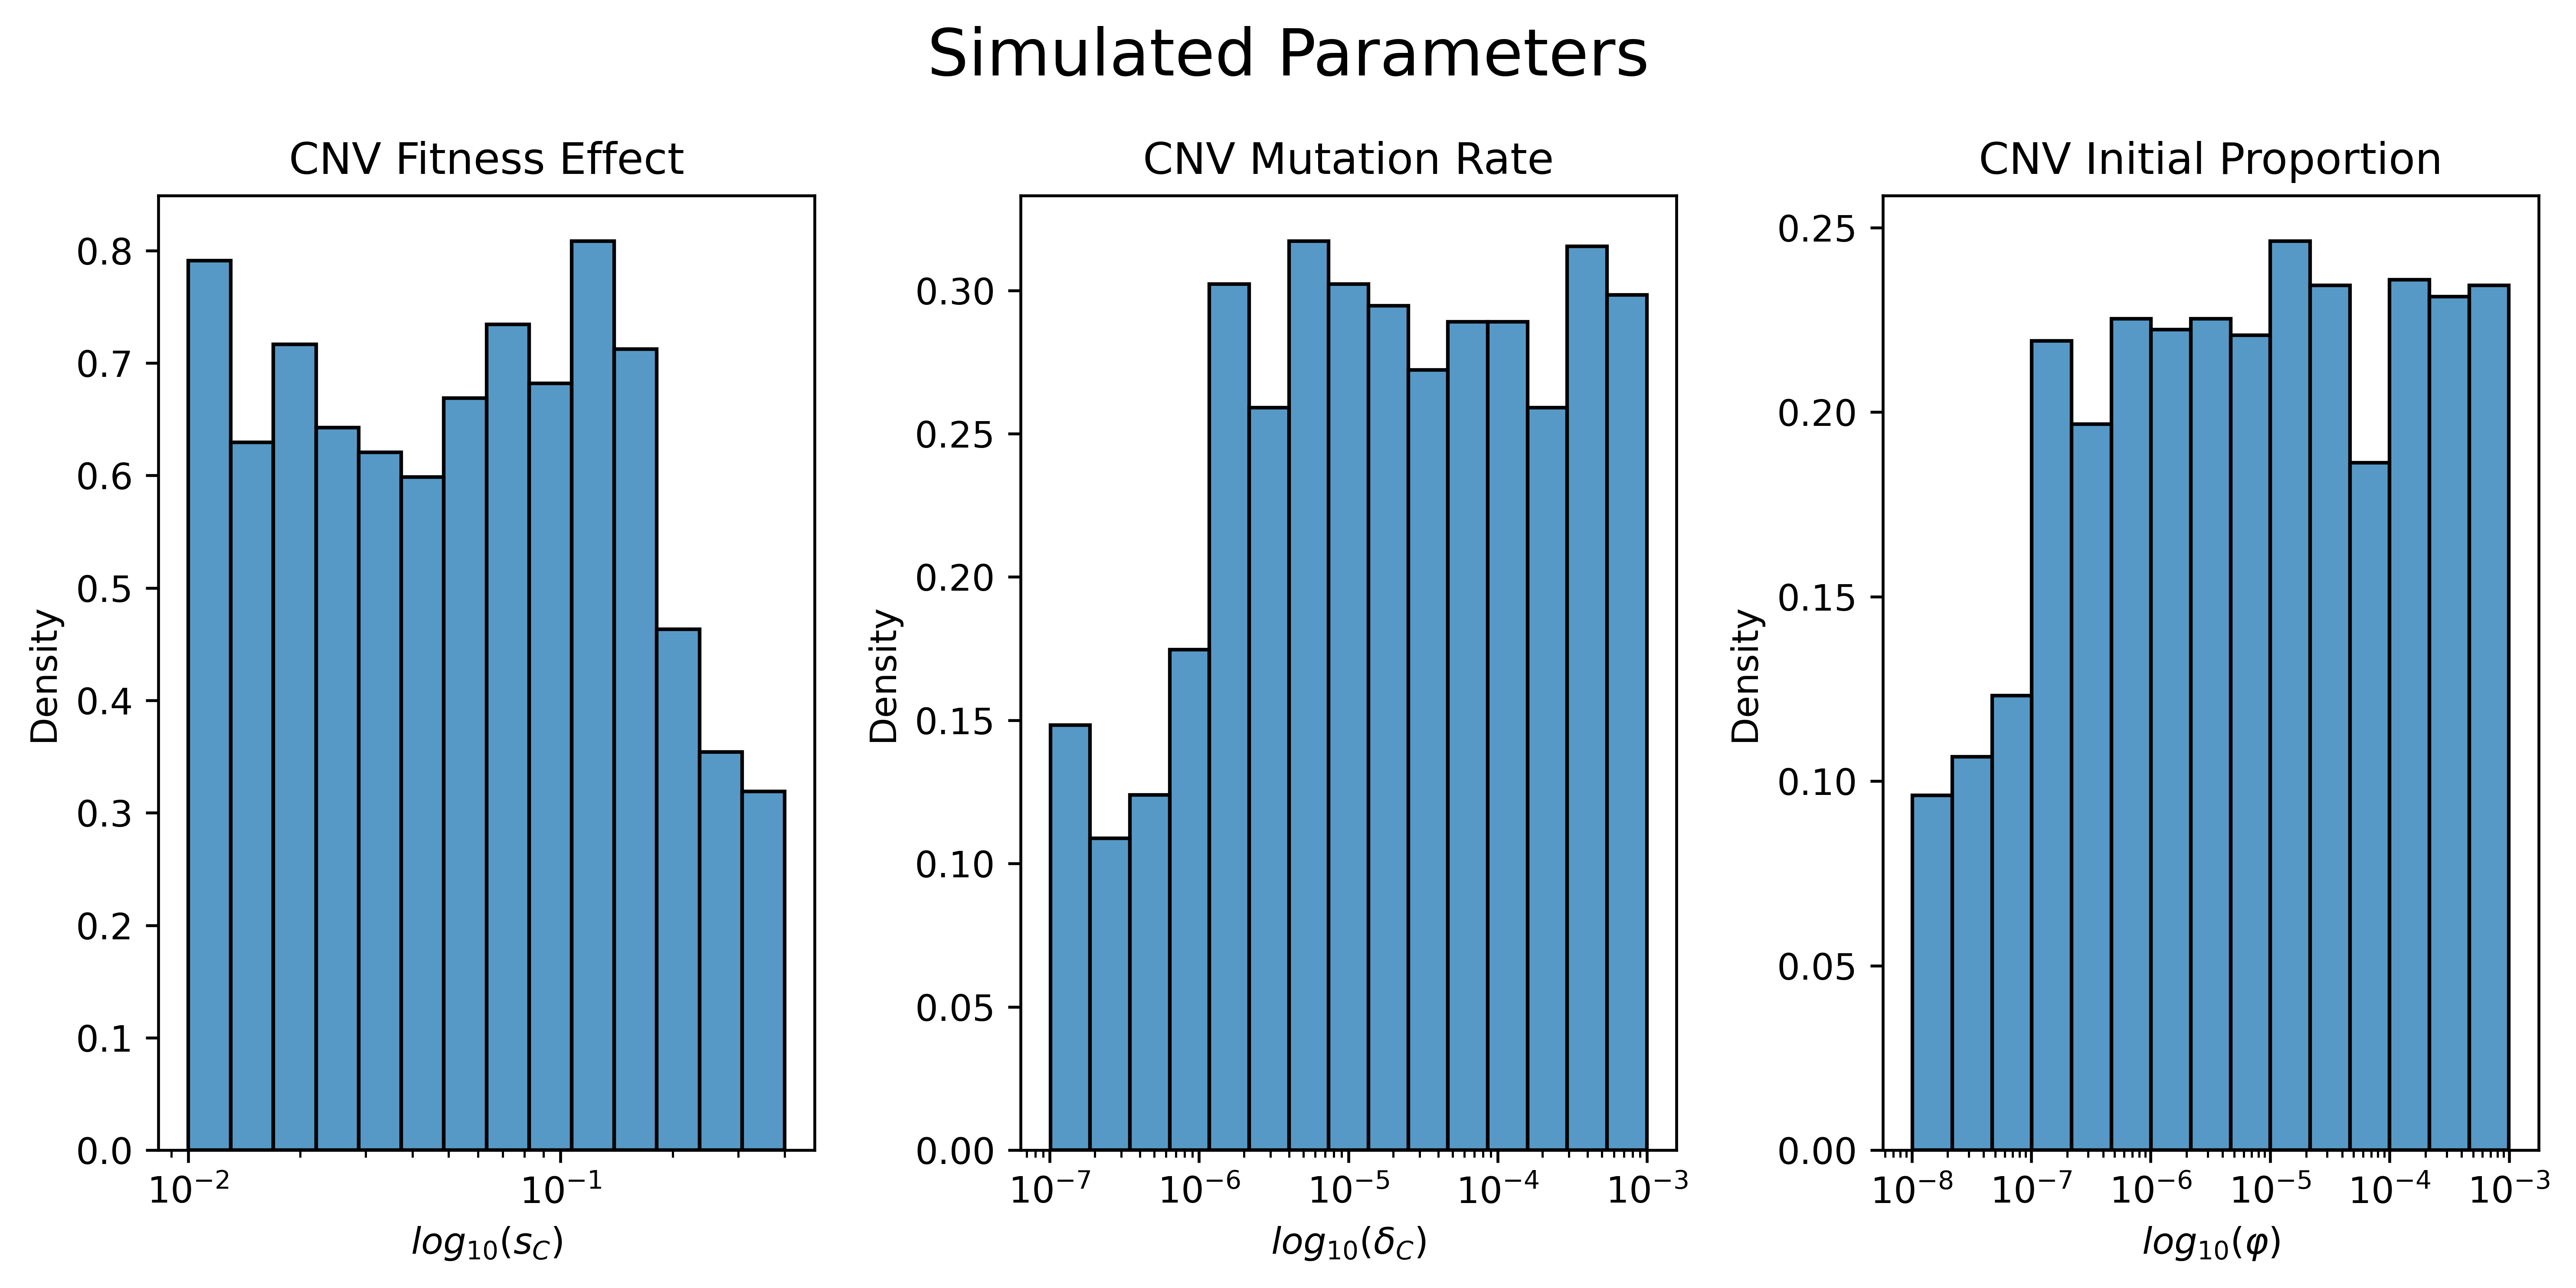

In [3]:
# Histograms of simulated parameters
from seaborn import histplot as hst

def plot_param(thetas,ax, loc, param):
    ax[loc[1]].set_xlabel(param)
    hst(10**thetas.iloc[:,2*loc[0]+loc[1]], ax = ax[loc[1]], fill=True, stat = 'density')

thetas = pd.read_csv('synthetic_tests/WF_presimulated_theta_2000_test.csv', index_col=0)
fig, ax = plt.subplots(1,3,figsize=(10,5), sharex = False, tight_layout=True)
fig.suptitle('Simulated Parameters', fontsize = 18)
ax[0].set_title('CNV Fitness Effect')
ax[0].set_xscale('log')
ax[1].set_title('CNV Mutation Rate')
ax[1].set_xscale('log')
ax[2].set_title('CNV Initial Proportion')
ax[2].set_xscale('log')

plot_param(thetas, ax, (0,0), param='$log_{10}(s_{C})$')
plot_param(thetas, ax, (0,1), param='$log_{10}(δ_{C})$')
plot_param(thetas, ax, (0,2), param='$log_{10}(φ)$')


## MAP estimations

In [4]:
%%capture
# Get simulations and simulated parameters
sims = pd.read_csv('synthetic_tests/WF_presimulated_data_2000_test.csv', index_col=0)
thetas = pd.read_csv('synthetic_tests/WF_presimulated_theta_2000_test.csv',index_col=0)
params = ['log_s', 'log_m', 'log_p']

# Infer simulations
def infer_on_sims(sims, thetas, posterior):
    inferred_df = pd.DataFrame(index = sims.index, columns = params+["est_"+param for param in params]+["ratio_"+param for param in params])

    for i in range(len(sims)):
        est = posterior.set_default_x(sims.iloc[i,:]).map(num_init_samples=100, num_iter=80)
        inferred_df.iloc[i,0:3] = thetas.iloc[i,:]
        inferred_df.iloc[i,3:6] = est
        inferred_df.iloc[i,6:] = est - np.array(thetas.iloc[i,:])
    return inferred_df

# Previously generated simulations
# inferred_df_noisy = infer_on_sims(sims, thetas, posterior_noisy)
# inferred_df_noisy.to_csv('synthetic_tests/inferred_df_noisy.csv')

inferred_df = pd.read_csv('synthetic_tests/inferred_sims_results.csv', index_col=0).iloc[:100,:]
inferred_df_ensemble = pd.read_csv('synthetic_tests/inferred_df_ensemble100.csv', index_col=0)
inferred_df_noisy = pd.read_csv('synthetic_tests/inferred_df_noisy100.csv', index_col=0)

## Plot $log_{10}(MAP/True)$

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0.01, '$log_{10}(MAP / True)$')

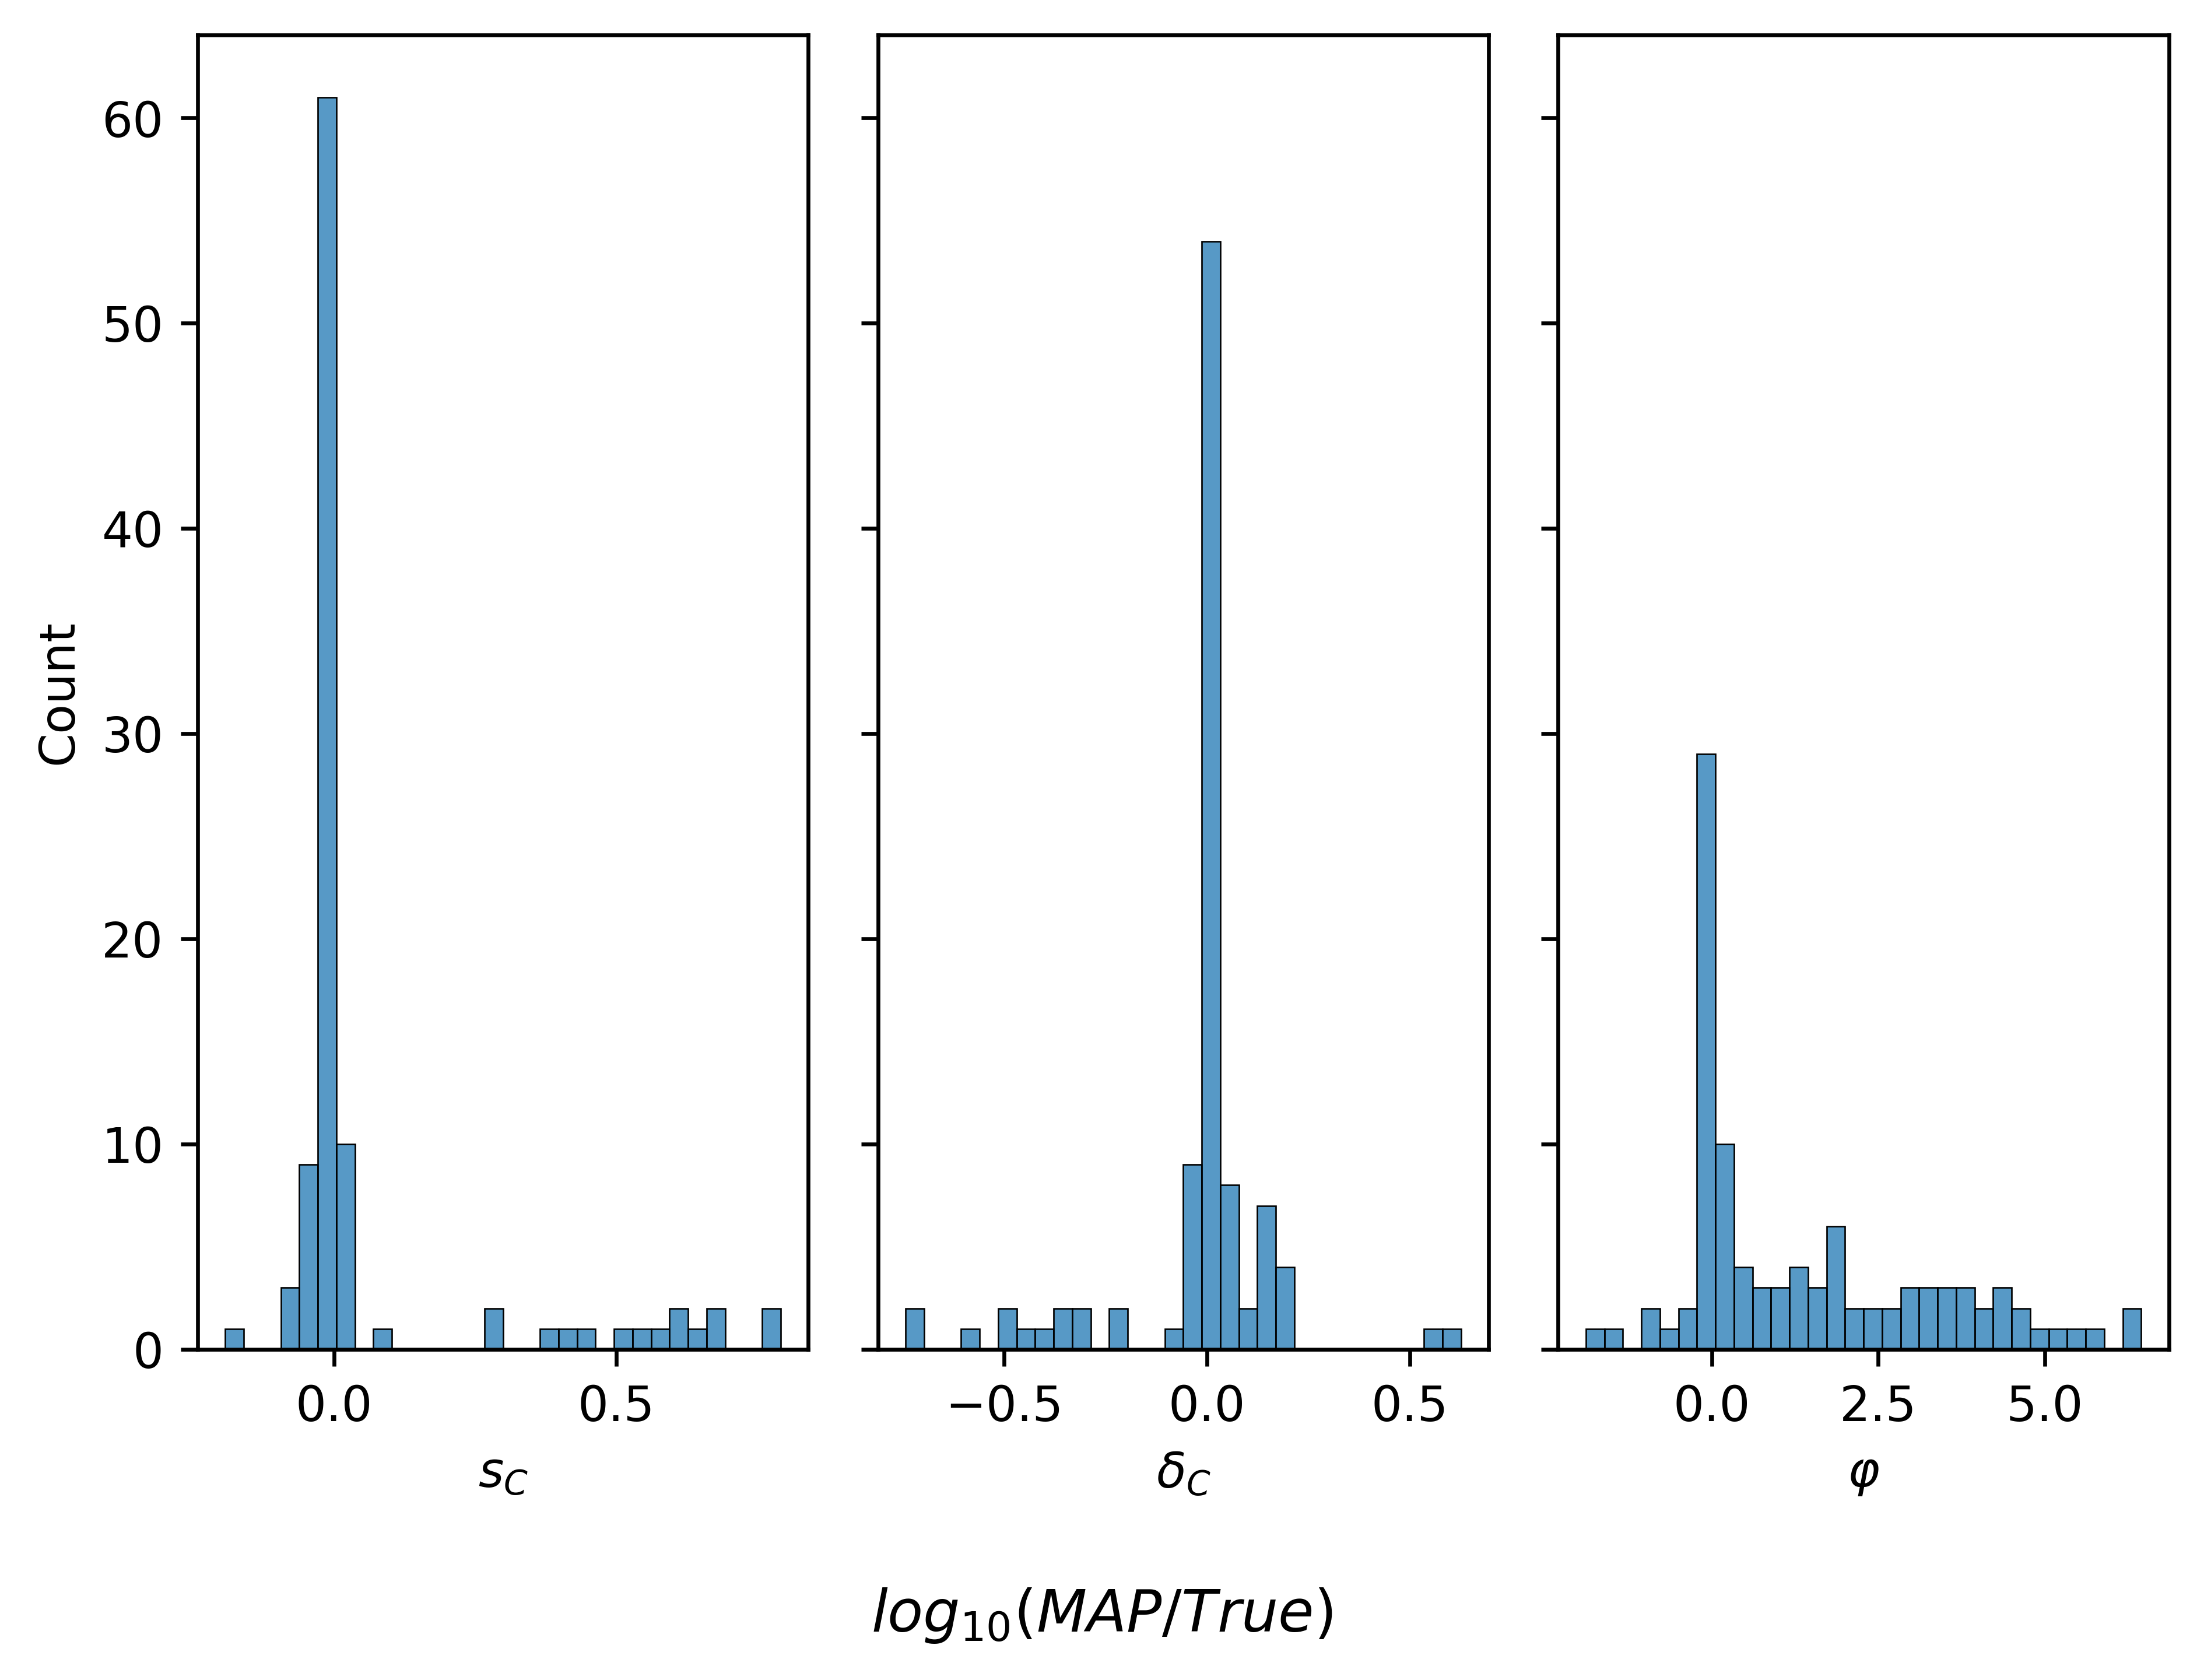

In [7]:
from seaborn import histplot
fig, ax = plt.subplots(1,3, tight_layout = True, sharey=True)

# Remove simulations with final CNV < 0.3
# inferred_df = inferred_df[sims['116']>=0.3]
for k in range(3):
    x=inferred_df.iloc[:,k-3].astype('float')
    histplot(ax=ax[k], x=x, bins=30, label='NPE')
    ax[k].set_xlabel(f'${thetas.columns[k][5:-2]}$') # Remove log() from title
fig.supxlabel('$log_{10}(MAP / True)$')

## Coverage ( $P(true$ $parameter \in 95\% $ $HDI)$ )

In [8]:
%%capture

# Get simulations

sims = pd.read_csv('synthetic_tests/WF_presimulated_data_2000_test.csv', index_col=0)
thetas = pd.read_csv('synthetic_tests/WF_presimulated_theta_2000_test.csv',index_col=0)

# Remove simulations with final CNV < 0.3
thetas = thetas[sims['116']>=0.3]
sims = sims[sims['116']>=0.3]

params = ['$log(s_C)$','$log(δ_C)$','$log(φ)$']

coverage = pd.DataFrame(columns=['coverage'], index = params, dtype='float')
coverage = coverage.fillna(0)
acc = 0.95
for i in range(len(sims)):
    samples = posterior_chuong.set_default_x(sims.iloc[i,:]).sample((200,))
    for j in range(len(params)):
        param = thetas.iloc[i,j]
        covered = int(min( samples.quantile((1-acc)/2) < param , param < samples.quantile((1-(1-acc)/2)) ))
        coverage.loc[params[j], 'coverage'] += covered
        
coverage = coverage / len(sims)

In [9]:
coverage.round(3)

,coverage
$log(s_C)$,0.990
$log(δ_C)$,0.995
$log(φ)$,0.931


# $\varphi$'s Range of Effect on Model Performance

Text(0, 0.5, 'CNV Frequency')

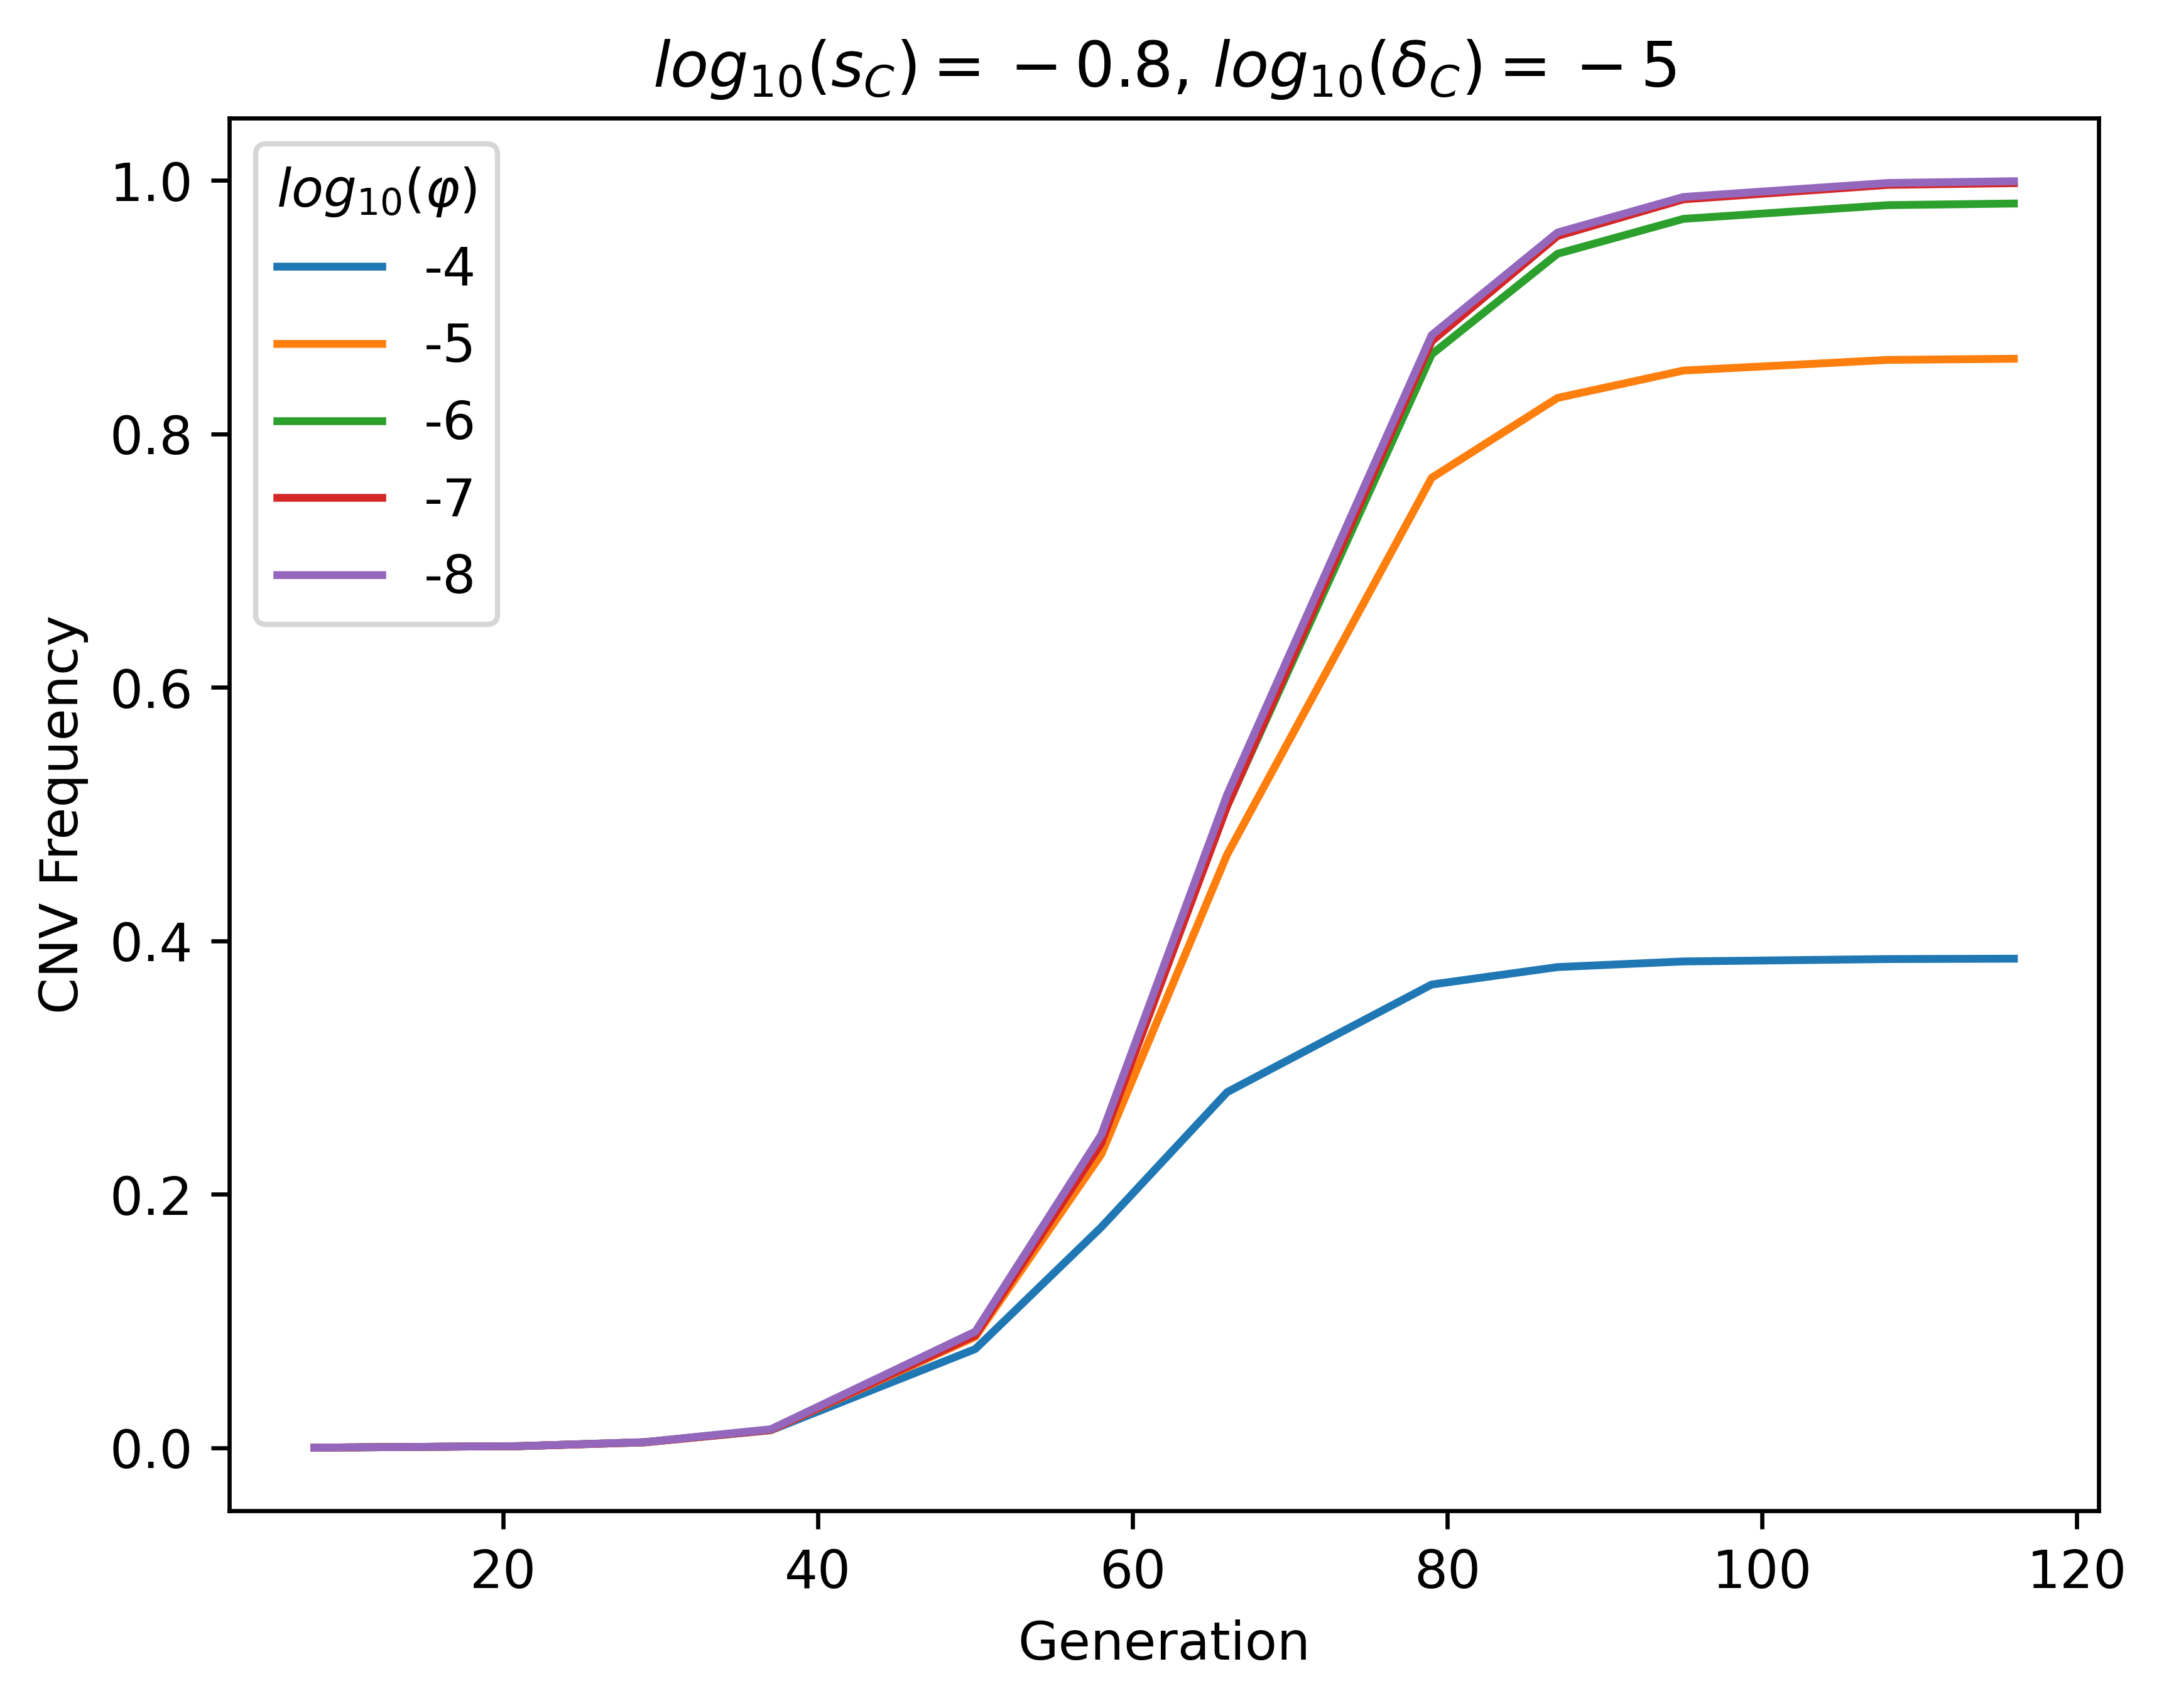

In [10]:
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF
import torch

reps = 1
generation = pd.read_csv('Chuong_116_gens.txt', delimiter = ', ', engine='python')
generation = generation.columns.astype('int')
N = 3.3e8

def CNVsimulator(cnv_params):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
    return states

params = [torch.tensor([-0.8,-5,-p], dtype=torch.float64) for p in range(4,9)]
for t in params:
    plt.plot(generation, CNVsimulator(t).T, label=int(t[-1]))

plt.legend(title='$log_{10}(φ)$')
plt.title('$log_{10}(s_C) = -0.8$, $log_{10}(δ_C)=-5$')
plt.xlabel('Generation')
plt.ylabel('CNV Frequency')